# Benchmarks for Microgrid environment

The notebook provides testing and comparison between deterministic policies and a pretrained RL agent strategies among the `MicroGridEnv` environment.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ../..

/Users/dave/Library/CloudStorage/OneDrive-PolitecnicodiMilano/PhD/Repositories/gym4ReaL


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from tqdm import tqdm
from collections import OrderedDict, defaultdict
from gymnasium.utils.env_checker import check_env
import gymnasium as gym

from gym4real.envs.microgrid.utils import parameter_generator

In [3]:
sns.set_theme()
sns.set_style('whitegrid')
sns.set_context("paper")
plot_colors = sns.color_palette('colorblind')
sns.set(font_scale=1.2)

alg_color = OrderedDict({
    'random': plot_colors[1],
    'battery_first': plot_colors[2],
    'only_market': plot_colors[3],
    'q-learning': plot_colors[0],
    'sarsa': plot_colors[4],
    'dqn': plot_colors[5],
    'ppo': plot_colors[6],
    '50-50': plot_colors[7]
})

alg_markers = OrderedDict({
    'random': '.',
    'longest_first': 'o',
    'shortest_first': 's',
    'q-learning': 's',
    'sarsa': 's',
})

alg_labels = {
    'random': 'Random',
    'battery_first': 'BF',
    'only_market': 'OM',
    'q-learning': 'Q-Learning',
    'sarsa': 'SARSA',
    'dqn': 'DQN',
    'ppo': 'PPO',
    '50-50': '50-50'
}

In [4]:
# IF RESULTS ARE ALREADY AVAILABLE, GO TO LAST CELLS TO LOAD THEM FROM JSON FILE AND DIRECTLY PLOT THEM!!

## Deterministic policies
Here we can evaluate different rule-based and deterministic policies.
Hereafter we will test:
1. random action policy
2. market-only policy
3. battery-first policy
5. 50/50 policy

In [5]:
params = parameter_generator(world_options='gym4real/envs/microgrid/world_test.yaml')
env = gym.make(id="gym4real/microgrid-v0", **{'settings':params})

/Users/dave/miniconda3/envs/gym4real/lib/python3.12/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/dave/miniconda3/envs/gym4real/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [6]:
# Test profiles belonging to the test set
test_profiles = [i for i in range(370, 398)]
rewards = defaultdict(dict)

<h3> Random Policy: </h3>
The action is chosen randomly at each decision step.

In [7]:
alg = 'random'
rewards[alg] = {}

for profile in tqdm(test_profiles):
    obs, info = env.reset(options={'eval_profile': str(profile)})
    done = False
    rewards[alg][profile] = {}
    rewards[alg][profile]['pure'] = []

    while not done:
        action = env.action_space.sample()  # Randomly select an action
        obs, reward, terminated, truncated, info = env.step(action)  
        done = terminated or truncated
        rewards[alg][profile]['pure'].append(list(info['pure_rewards'].values()))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [01:27<00:00,  3.12s/it]


<h3> Only Market Policy: </h3>
The action chosen is always 0, meaning that the battery is never used.

In [8]:
alg = 'only_market'
rewards[alg] = {}

for profile in tqdm(test_profiles):
    obs, info = env.reset(options={'eval_profile': str(profile)})
    done = False
    rewards[alg][profile] = {}
    rewards[alg][profile]['pure'] = []

    while not done:
        action = np.array([0]) # Only trading with market
        obs, reward, terminated, truncated, info = env.step(action)  
        done = terminated or truncated
        rewards[alg][profile]['pure'].append(list(info['pure_rewards'].values()))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:58<00:00,  2.10s/it]


<h3> Battery First Policy: </h3>
The action chosen is always 1, meaning that the battery is always used before interacting with the market.

In [9]:
alg = 'battery_first'
rewards[alg] = {}

for profile in tqdm(test_profiles):
    obs, info = env.reset(options={'eval_profile': str(profile)})
    done = False
    rewards[alg][profile] = {}
    rewards[alg][profile]['pure'] = []

    while not done:
        action = np.array([1])  # Use the battery as much as possible 
        obs, reward, terminated, truncated, info = env.step(action)  
        done = terminated or truncated
        rewards[alg][profile]['pure'].append(list(info['pure_rewards'].values()))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [01:18<00:00,  2.82s/it]


<h3> 50-50 Policy: </h3>
The action chosen is always 0.5, meaning that the battery is never used.

In [10]:
alg = '50-50'
rewards[alg] = {}

for profile in tqdm(test_profiles):
    obs, info = env.reset(options={'eval_profile': str(profile)})
    done = False
    rewards[alg][profile] = {}
    rewards[alg][profile]['pure'] = []

    while not done:
        action = np.array([0.5])  # Use the battery at 50%
        obs, reward, terminated, truncated, info = env.step(action)  
        done = terminated or truncated
        rewards[alg][profile]['pure'].append(list(info['pure_rewards'].values()))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [01:21<00:00,  2.90s/it]


### PPO agent
Here we load the previously created model `PPO_trained`.

In [11]:
# Uncomment the following line to install stable-baselines3
#!pip install stable-baselines3

In [12]:
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.common.env_util import make_vec_env

In [13]:
env = make_vec_env("gym4real/microgrid-v0", n_envs=1, env_kwargs={'settings':params})

alg = 'ppo'
rewards[alg] = {}

model = PPO(MlpPolicy, env, verbose=1)
vec_env = model.get_env()
model = PPO.load("examples/microgrid/trained_models/PPO_trained")

for profile in tqdm(test_profiles):
    vec_env.set_options({'eval_profile': str(profile)})
    obs = vec_env.reset()

    cumulated_reward = 0
    rewards[alg][profile] = {}
    rewards[alg][profile]['pure'] = []
    done = False
    
    while not done:
        action, _states = model.predict(obs)
        obs, r, dones, info = vec_env.step(action)
        done = dones[0]
        rewards[alg][profile]['pure'].append(list(info[0]['pure_rewards'].values()))

/Users/dave/miniconda3/envs/gym4real/lib/python3.12/site-packages/gymnasium/envs/registration.py:736: UserWarning: WARN: The environment is being initialised with render_mode='rgb_array' that is not in the possible render_modes ([]).
  logger.warn(
/Users/dave/miniconda3/envs/gym4real/lib/python3.12/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/dave/miniconda3/envs/gym4real/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Using cpu device


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [01:49<00:00,  3.91s/it]


## Result analysis
Here we compare the average cumulated reward across all the test profiles among the different methods.

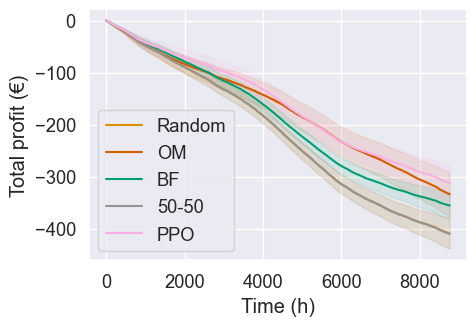

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3.5), tight_layout=True)

for i, alg in enumerate(rewards.keys()):
    cum_rewards = []
    for profile in rewards[alg].keys():
        cum_rewards.append(np.cumsum([rewards[alg][profile]['pure'][i][0] + rewards[alg][profile]['pure'][i][1] for i in range(len(rewards[alg][profile]['pure']))]))
    
    means = np.mean(cum_rewards, axis=0)
    stds = np.std(cum_rewards, axis=0)
    ci = 1.96 * stds/np.sqrt(len(rewards[alg].keys()))
    
    ax.plot(means, label=alg_labels[alg], color=alg_color[alg])        
    ax.fill_between(range(len(means)), means + ci, means - ci, color=alg_color[alg], alpha=0.1)

ax.legend()
# Set axis labels
ax.set_xlabel("Time (h)")
ax.set_ylabel("Total profit (€)")

# Add legend
ax.legend()

# Save figure
plt.savefig('plots/microgrid_avg_reward.pdf')

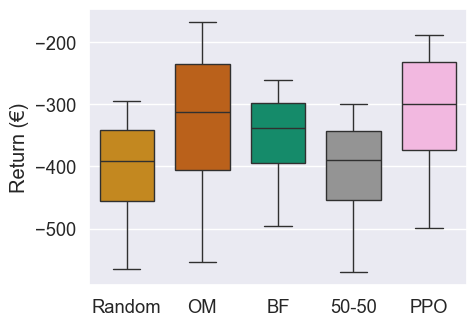

In [26]:
from matplotlib.ticker import ScalarFormatter

box_data = {}
colors = []

for alg in rewards.keys():
    box_data[alg_labels[alg]] = []
    
    for profile in rewards[alg].keys():
        total_trad = np.sum([rewards[alg][profile]['pure'][i][0] for i in range(len(rewards[alg][profile]['pure']))])
        total_deg = np.sum([rewards[alg][profile]['pure'][i][1] for i in range(len(rewards[alg][profile]['pure']))])
        box_data[alg_labels[alg]].append(total_trad + total_deg)

    colors.append(alg_color[alg])
        
fig, ax = plt.subplots(figsize=(5, 3.5), tight_layout=True)
box_plot = sns.boxplot(box_data, gap=.1, palette=colors, width=.8)

# Label the axes
ax.set_ylabel(r"Return (€)")

# Use scientific notation on y-axis
formatter = ScalarFormatter()
formatter.set_scientific(True)
formatter.set_powerlimits((-2, 3))  # Show scientific notation when appropriate
ax.yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.savefig("plots/microgrid_boxplot.pdf")